# 215 degree arc

The problem provided in this example is a $215^\circ$ arch with pinned-fixed boundary conditions subjected to a point load at the center of the arch. The arch is modeled with 2D geometrically exact beams (i.e. Simo-Reissner Beams). For more information on beams [see here](../README.md).


<img src="imgs/arch_215.png" width="600">


In [1]:
%matplotlib inline
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
from ufl import diag, Jacobian, shape
import os
os.chdir('../../../..') # change directory to main module directory
from arc_length.force_control_solver import force_control # import force control formulation of arc-length solver

parameters["form_compiler"]["representation"] = "uflacs"
parameters["form_compiler"]["optimize"] = True
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["quadrature_degree"] = 1
parameters['reorder_dofs_serial'] = False


ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}

## Import Mesh and define function spaces
In the case of 2D beams we also define the rotation matrix about the $z$ axis and directional derivative with respect to the beam centerline.

In [2]:
mesh_215 = Mesh()
with XDMFFile(os.getcwd()+'/examples/force_control/beam/beam_2D/mesh/215_arch2D.xdmf') as infile:
    infile.read(mesh_215)
    

Ue = VectorElement("CG", mesh_215.ufl_cell(), 1, dim=2) # displacement
Te = FiniteElement("CG", mesh_215.ufl_cell(), 1) # rotation
V = FunctionSpace(mesh_215, MixedElement([Ue, Te]))   

v_ = TestFunction(V)
u_, theta_ = split(v_)
dv = TrialFunction(V)
v = Function(V, name="Generalized displacement")
u, theta = split(v)

VR = TensorFunctionSpace(mesh_215, "DG", 0, shape=(2, 2))

V0 = FunctionSpace(mesh_215, "DG", 0)


Vu = V.sub(0).collapse()
disp = Function(Vu)

Jac = Jacobian(mesh_215)
gdim = mesh_215.geometry().dim()
Jac = as_vector([Jac[i, 0] for i in range(gdim)])
g01 = Jac/sqrt(dot(Jac, Jac))
g02 = as_vector([-g01[1],g01[0]])

r01 = outer(g01,as_vector([1,0]))
r02 = outer(g02, as_vector([0,1]))

R0 = r01+r02

#-----------------------Define Functions for beams-----------------------------------#
def tgrad(u): # directional derivative w.r.t. beam centerline
    return dot(grad(u), g01)

def rotation_matrix(theta): # 2D rotation matrix -- there is no need to do rotation parametrization for 2D beams
    return as_tensor([[cos(theta), -sin(theta)],[sin(theta), cos(theta)]])
Rot = rotation_matrix(theta)

## Define Dirichlet Boundary Conditions

In [3]:
r = 100
arch = 215

left_theta =180+(90-(360-arch)/2)
right_theta = -(90-(360-arch)/2)

def x_coord(r,theta):
        return r*np.cos(np.deg2rad(theta))

def y_coord(r,theta):
        return r*np.sin(np.deg2rad(theta))
    
x_coord_left = x_coord(r,left_theta)
y_coord_left = y_coord(r,left_theta)
x_coord_right = x_coord(r,right_theta)
y_coord_right = y_coord(r,right_theta)

In [4]:
def pinned_left(x, on_boundary):
    return near(x[0], x_coord_left, 1e-6)   

def fixed_right(x, on_boundary):
    return near(x[0], x_coord_right, 1e-6)

def load_center(x, on_boundary):
    return near(x[1], r, 1e-6)

# Mark integration boundary
facets = MeshFunction("size_t", mesh_215, 0)
facets.set_all(0)
AutoSubDomain(load_center).mark(facets,1)

Pinned = DirichletBC(V.sub(0), Constant((0.0, 0.0)), pinned_left, method='pointwise') # Fixed displacement
Fixed = DirichletBC(V, Constant((0.0, 0.0, 0.0)), fixed_right, method='pointwise') # Fixed displacement and rotation
bcs = [Pinned, Fixed]

## Kinematics and Weak form

In [5]:
# 2D beam Kinematics
defo = dot(R0.T,dot(Rot.T, g01 + tgrad(u)) - g01)
curv =  tgrad(theta)

In [6]:
# Geometrical properties
S = 2.29 # cross-sectional area
I = 1.0 # Area moment
J = 2.0 # Polar Moment
E = 1.0e6 # Elastic modulus
nu = 0 # Poisson's Ratio

G = E/(2*(1+nu)) # Shear Modulus
kappa = 1.0 # Shear correction

# Stiffness moduli
ES = E*S
GS = G*S
GS_2 = G*S*kappa
GS_3 = G*S*kappa
EI = E*I

In [7]:
# Constitutive Equations
C_N = diag(as_vector([ES, GS_2]))

# Applied Load:
F_max = Constant((0.0,-1.0))
M_max = Constant(0.0)
load = Expression("t", t=0, degree = 0)

dS = Measure("dS", domain=mesh_215, subdomain_data=facets) # Note its dS not ds -- interior facet
dx = Measure("dx", domain=mesh_215)

elastic_energy = 0.5 * (dot(defo, dot(C_N, defo)) + (EI*curv**2))*dx

F_int = derivative(elastic_energy, v, v_)
F_ext = avg(load * (-M_max*theta_ + dot(F_max, u_))) * dS(1) # avg function is used to integrte over disconticuous interior facets
residual = F_int - F_ext
tangent_form = derivative(residual, v, dv)

## Solver
To use our solver we first have to define the type of solver (i.e. displacement control or force control) and solver parameters before using the solver. Note that the correct type of solver has to first be imported (see first cell).
### Solver parameters
Here the parameters for both types of solvers:

>* `psi` : the scalar arc-legth parameter. When psi = 1, the method becomes the shperical arc-length method and when psi = 0 the method becomes the cylindrical arc-length method
>* `tol` : tolerance for the linear solver
>* `lmbda0` : the initial load parameter
>* `max_iter` : maximum number of iterations for the linear solver
>* `solver` : (optional): type of linear solver for the FEniCS linear solve function -- default FEniCS linear solver is used if no argument is used.

Aside from these solver parameters, the arguments need to solve the FEA problem must also be passed into the solver:
>* `u` : the solution function
>* `F_int` : First variation of strain energy (internal nodal forces)
>* `F_ext` : Externally applied load (external applied force)
>* `J` : The Jacobian of the residual with respect to the deformation (tangential stiffness matrix)
>* `load_factor` : The incremental load factor 

The solver can be called by:
`solver = force_control(psi,tol,lmbda0,max_iter,u,F_int,F_ext,bcs,J,load_factor,solver)`

### Using the solver
1. Initialize the solver by calling solver.initialize()
2. Iteratively call solver.solve() until desired stopping condition

In [8]:
# Solver Parameters
psi = 1.0
tol = 1.0e-6
lmbda0 = 50.0
max_iter = 10
solver = 'mumps' # optional

# Set up force control arc-length solver
solver = force_control(psi=psi, tol=tol, lmbda0=lmbda0, max_iter=max_iter, u=v,
                       F_int=F_int, F_ext=F_ext, bcs=bcs, J=tangent_form, load_factor=load, solver=solver)

In [9]:
# Iterative solving 
disp = [v.vector()[:]]
lmbda = [0]
solver.initial_step()

for ii in range(99):
    solver.solve()
    if solver.converged: # We only want to save the solution step if the solver coverges 
        disp.append(v.vector()[:])
        lmbda.append(load.t)

Starting initial Force Control with Newton Method:
Iteration 0: 
Residual error: 5.0000e+01
Iteration 1: 
Residual error: 8.7164e+02
Iteration 2: 
Residual error: 7.6766e+00
Iteration 3: 
Residual error: 1.4991e+00
Iteration 4: 
Residual error: 4.7541e-05
Iteration 5: 
Residual error: 2.9493e-09

Arc-Length Step 1 :
Iteration: 1 
|Total Norm: 2.9493e-09 |Residual Norm: 2.9493e-09 |A: -4.5475e-13|

Arc-Length Step 2 :
Iteration: 1 
|Total Norm: 2.1210e+03 |Residual Norm: 2.1210e+03 |A: -4.5475e-13|
Iteration: 2 
|Total Norm: 1.9729e+01 |Residual Norm: 1.9726e+01 |A: 3.5863e-01|
Iteration: 3 
|Total Norm: 9.3217e+00 |Residual Norm: 9.0868e+00 |A: 2.0795e+00|
Iteration: 4 
|Total Norm: 2.0805e-03 |Residual Norm: 2.0373e-03 |A: 4.2200e-04|
Iteration: 5 
|Total Norm: 1.0529e-07 |Residual Norm: 1.0298e-07 |A: 2.1918e-08|

Arc-Length Step 3 :
Iteration: 1 
|Total Norm: 2.7079e+03 |Residual Norm: 2.7079e+03 |A: 2.1919e-08|
Iteration: 2 
|Total Norm: 2.2988e+01 |Residual Norm: 2.2983e+01 |A: 4.

## Post Processing
Here we plot the final deformed shape and the equilibrium path. To verify or solution, we also compare our solutions to ones found in literature.

Solutions are obtained from the paper: [A simple extrapolated predictor for overcoming the starting and tracking issues in the arc-length method for nonlinear structural mechanics](https://www.sciencedirect.com/science/article/pii/S014102962034356X)

In [10]:
# Get dof coordinates:
x_dofs = V.sub(0).sub(0).dofmap().dofs()
y_dofs = V.sub(0).sub(1).dofmap().dofs()
theta_dofs = V.sub(1).dofmap().dofs()
dofs = V.tabulate_dof_coordinates()
dof_coords = dofs.reshape((-1, 2))

eps = 1e-5
dof = []
# Identify y-dof at the center of the arch for force application
for ii in y_dofs:
    if abs(dof_coords[ii,0]) <= eps:
        force_dof = ii

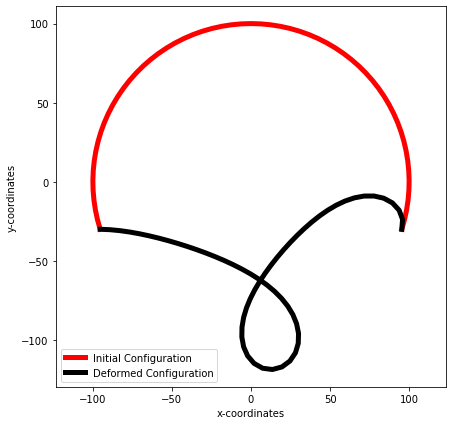

In [11]:
# Get nodal values 
x_nodal_coord = dof_coords[x_dofs][:,0]
y_nodal_coord = dof_coords[y_dofs][:,1]

# Plot displacement field
disp_x = x_nodal_coord + disp[-1][x_dofs]
disp_y = y_nodal_coord + disp[-1][y_dofs]

plt.figure(figsize=(7,7))
plt.plot(x_nodal_coord,y_nodal_coord, c = 'r', lw = 5, label = 'Initial Configuration')
plt.plot(disp_x, disp_y, c = 'k', lw = 5, label = 'Deformed Configuration')

plt.xlabel('x-coordinates')
plt.ylabel('y-coordinates')
plt.axis('equal')
plt.legend()
plt.show()

Text(0.5, 0, 'Normalized Displacement')

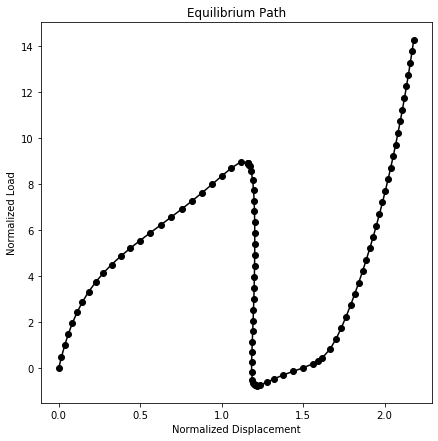

In [12]:
# Get displacment at force application
force_disp = []
for ii in range(len(disp)):
    force_disp.append(disp[ii][force_dof])
# Normalize values
displacement_normalized = -np.array(force_disp)/r


lamda_normalized = (np.array(lmbda)*r**2)/EI

plt.figure(figsize=(7,7))
plt.plot(displacement_normalized, lamda_normalized, c = 'k', marker = 'o')
plt.title('Equilibrium Path')
plt.ylabel('Normalized Load')
plt.xlabel('Normalized Displacement')

In [13]:
# get paper solution
import scipy.io
paper_soln = scipy.io.loadmat(os.getcwd()+'/examples/force_control/beam/beam_2D/lit_soln/solution_215.mat')

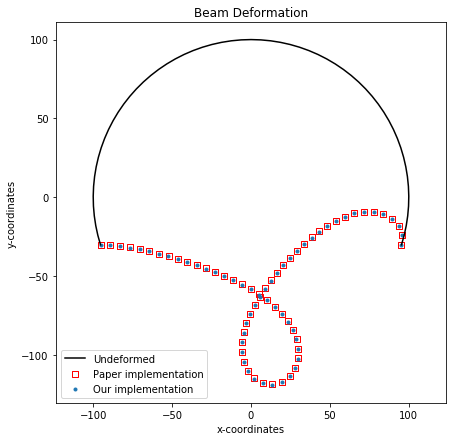

In [14]:
plt.figure(figsize=(7,7))
plt.scatter(paper_soln['soln'][:,0],paper_soln['soln'][:,1], label = 'Paper implementation', facecolors = 'None', edgecolors = 'r', marker = 's')
plt.scatter(disp_x, disp_y, marker = '.', label = 'Our implementation')
plt.plot(x_nodal_coord,y_nodal_coord,label = 'Undeformed', color = 'k')

plt.xlabel('x-coordinates')
plt.ylabel('y-coordinates')
plt.title('Beam Deformation')
plt.axis('equal')
plt.legend()
plt.show()

In [15]:
# get paper equilibrium path
paper_eq = np.loadtxt(os.getcwd()+'/examples/force_control/beam/beam_2D/lit_soln/path_215.dat')

buckling load: 8.963047469772224
Error: -0.0007750869819148741


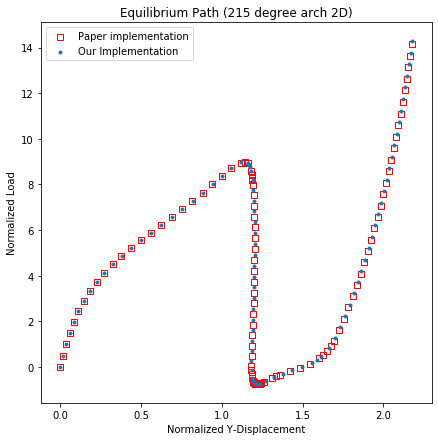

In [16]:
plt.figure(figsize=(7,7))
plt.scatter(-paper_eq[:,2]/r, paper_eq[:,0]*r**2/EI, label = 'Paper implementation', facecolors = 'None', edgecolors = 'r', marker = 's')

plt.scatter(displacement_normalized, lamda_normalized, marker = '.', label = 'Our Implementation')
plt.title('Equilibrium Path (215 degree arch 2D)')
plt.ylabel('Normalized Load')
plt.xlabel('Normalized Y-Displacement')
plt.legend()

idx = np.where(displacement_normalized<1.5)

print('buckling load:',np.max(lamda_normalized[idx]))
print('Error:',(np.max(lamda_normalized[idx]) - 8.97)/8.97)

## Optional: Creating an animation from solution snapshots

In [17]:
from matplotlib import animation, rc

plt.rcParams["animation.html"] = "jshtml"

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

ax.set_xlim([-150,150])
ax.set_ylim([-150,150])

deformed, = ax.plot([], [], lw = 7, c = 'r', label = 'Deformed Configuration')
init, = ax.plot(x_nodal_coord, y_nodal_coord, c='k', lw = 5, ls = ':', label = 'Initial Configuration')
ax.legend(loc = 'lower right')

def drawframe(n):
    disp_x = x_nodal_coord + disp[n][x_dofs]
    disp_y = y_nodal_coord + disp[n][y_dofs]
    
    deformed.set_data(disp_x,disp_y)
    return deformed,

plt.close()
# Note: blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(lmbda), interval=40, blit=True)

anim